In [1]:
#!wget http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes

In [2]:
!ls /Users/lxf453/jupyter/Labtools/

apply_multiprocessing.py  apply_multiprocessing.pyc


In [4]:
import pandas as pd 
import numpy as np
import subprocess
from tqdm import tqdm_notebook
import re
from multiprocessing import Pool
import reprlib
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

In [5]:
!cat hg19.chrom.sizes|head -n24 >  hg19.chrom_main_chrs.sizes
!cat hg19.chrom.sizes|head -n1 >  hg19.chrom_main_1_samples_chrs.sizes
!cat hg19.chrom_main_chrs.sizes_chr1_apenas

cat: hg19.chrom_main_chrs.sizes_chr1_apenas: No such file or directory


In [6]:
!echo 'chr2	243199373' > hg19.chrom_main_2_samples_chrs.sizes

In [7]:
def print_special(x):
    print '<'*20 + str(x) + '>'*20
    
def generate_window_atac_seq(atac_file='', chr_file=''):
    '''
    atac_file : bam file (str)
    chr_file : chr size file  (str)
    '''
    os.system('cat > ')
    df_chr_sizes = pd.read_csv(chr_file,
                sep='\t',
                names=['chr', 'len'])
    file_names = []
    for chr_i, len_chr in df_chr_sizes.values:
        #print chr_i, len_chr
        pairs_distance= []
        
        window_coord = '{}:{}-{}'.format(chr_i,
                                         str(0),
                                         str(len_chr) )
        #print window_coord
        out_name = '_'.join( [chr_i, str(0), str(len_chr), '.sam_out'] )
        chr_df_read_file_name = '{}_selected.sam'.format(out_name.rstrip('.sam_out'))
        save_chr_buffer = open(chr_df_read_file_name,'w')
        print_special(window_coord)
        cmd='samtools view {} "{}" |grep -v "*" > {}'.format(atac_file,
                                               window_coord,
                                               out_name)
       
        print 'Extracting bam file informations'
        print cmd
        sam_values = subprocess.check_output(cmd, shell=True).split('\n')[:-1]
        
        print 'Processing lenghts...'
        
        #plt.figure(figsize=(5, 1))
        #plt.xlim([-w_value, w_value])
        # prevents error creating additional coliumns
        
        for chunk_pandas in pd.read_csv(out_name, chunksize=1000000, header=None, sep='\t', usecols=range(9)):
            
            saving_chunck_selected_buffer = []
            for s_p in chunk_pandas[ np.abs(chunk_pandas[8]) < 800 ].values:
                distance = s_p[8]
                pair_1 = s_p[3]
                pair_2 = s_p[7]
                read_len = int(re.search('(\d+)\D' , s_p[5]).group(1))
                #read_center = int(pair_1 + abs(distance/2.0))
                if read_len >50:
                    pairs_distance.append(abs(distance) )
                    saving_chunck_selected_buffer.append( '\t'.join(map(str, [s_p[0]] + [abs(distance)])) )
                       
            save_chr_buffer.write('\n'+'\n'.join(saving_chunck_selected_buffer))  
        save_chr_buffer.close()
        file_names.append(chr_df_read_file_name)
    return file_names

resu = generate_window_atac_seq(atac_file='../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam',
                         chr_file='hg19.chrom_main_chrs.sizes')

<<<<<<<<<<<<<<<<<<<<chr1:0-249250621>>>>>>>>>>>>>>>>>>>>
Extracting bam file informations
samtools view ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam "chr1:0-249250621" |grep -v "*" > chr1_0_249250621_.sam_out
Processing lenghts...
<<<<<<<<<<<<<<<<<<<<chr2:0-243199373>>>>>>>>>>>>>>>>>>>>
Extracting bam file informations
samtools view ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam "chr2:0-243199373" |grep -v "*" > chr2_0_243199373_.sam_out
Processing lenghts...
<<<<<<<<<<<<<<<<<<<<chr3:0-198022430>>>>>>>>>>>>>>>>>>>>
Extracting bam file informations
samtools view ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam "chr3:0-198022430" |grep -v "*" > chr3_0_198022430_.sam_out
Processing lenghts...
<<<<<<<<<<<<<<<<<<<<chr4:0-191154276>>>>>>>>>>>>>>>>>>>>
Extracting bam file informations
samtools view ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam "chr4:0-191154276" |grep -v "*" > chr4_0_191154276_.sam_out
Processing lenghts...
<<<<<<<<<<<<

In [8]:
resu

['chr1_0_249250621_selected.sam',
 'chr2_0_243199373_selected.sam',
 'chr3_0_198022430_selected.sam',
 'chr4_0_191154276_selected.sam',
 'chr5_0_180915260_selected.sam',
 'chr6_0_171115067_selected.sam',
 'chr7_0_159138663_selected.sam',
 'chrX_0_155270560_selected.sam',
 'chr8_0_146364022_selected.sam',
 'chr9_0_141213431_selected.sam',
 'chr10_0_135534747_selected.sam',
 'chr11_0_135006516_selected.sam',
 'chr12_0_133851895_selected.sam',
 'chr13_0_115169878_selected.sam',
 'chr14_0_107349540_selected.sam',
 'chr15_0_102531392_selected.sam',
 'chr16_0_90354753_selected.sam',
 'chr17_0_81195210_selected.sam',
 'chr18_0_78077248_selected.sam',
 'chr20_0_63025520_selected.sam',
 'chrY_0_59373566_selected.sam',
 'chr19_0_59128983_selected.sam',
 'chr22_0_51304566_selected.sam',
 'chr21_0_48129895_selected.sam']

In [13]:
files_selected = !ls *_selected.sam

In [14]:
def concat_chrs_prediction(df_x, name_file):
    print 'saving slices...'
    for c,v in df_x.groupby('nucleo_class'):
        n_out = '{}_{}.out_to_concat'.format(name_file, c)
        v.to_csv(n_out, header=None, sep='\t', index=None)

/Users/lxf453/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  import sys


Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


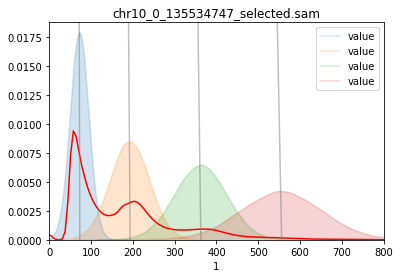

                                           0   1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:4:12404:12649:4592  60  nucleossome_free_region   
1  NS500627:136:HY2CNBGXX:4:12404:12649:4592  60  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:4:21512:6173:19777  76  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:4:21512:6173:19777  76  nucleossome_free_region   
4  NS500627:136:HY2CNBGXX:3:21501:10635:6356  62  nucleossome_free_region   

   prob_nucleo_class  
0           0.991393  
1           0.991393  
2           0.982167  
3           0.982167  
4           0.990771  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


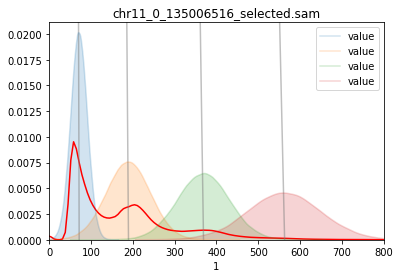

                                            0    1             nucleo_class  \
0    NS500627:136:HY2CNBGXX:4:12503:4072:9526  247                     Mono   
1    NS500627:136:HY2CNBGXX:4:12503:4072:9526  247                     Mono   
2  NS500627:136:HY2CNBGXX:3:12410:22432:15718   51  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:3:12410:22432:15718   51  nucleossome_free_region   
4   NS500627:136:HY2CNBGXX:1:23303:4017:19854  339                 dinucleo   

   prob_nucleo_class  
0           0.933269  
1           0.933269  
2           0.979502  
3           0.979502  
4           0.928068  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


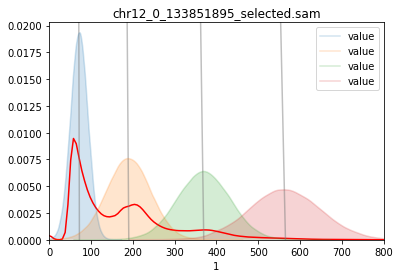

                                            0    1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:3:11611:10917:14867   84  nucleossome_free_region   
1  NS500627:136:HY2CNBGXX:4:13611:22642:14930  133                     Mono   
2  NS500627:136:HY2CNBGXX:3:11611:10917:14867   84  nucleossome_free_region   
3   NS500627:136:HY2CNBGXX:1:21305:13654:5809   77  nucleossome_free_region   
4   NS500627:136:HY2CNBGXX:1:21305:13654:5809   77  nucleossome_free_region   

   prob_nucleo_class  
0           0.945472  
1           0.940349  
2           0.945472  
3           0.963224  
4           0.963224  
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
saving slices...


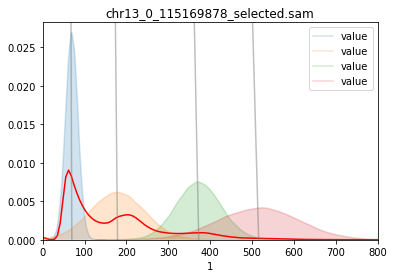

                                            0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:1:21308:18657:5914  323                 dinucleo   
1  NS500627:136:HY2CNBGXX:1:13111:10620:10687  129                     Mono   
2  NS500627:136:HY2CNBGXX:1:13111:10620:10687  129                     Mono   
3   NS500627:136:HY2CNBGXX:1:21308:18657:5914  323                 dinucleo   
4  NS500627:136:HY2CNBGXX:4:21412:16680:10114   68  nucleossome_free_region   

   prob_nucleo_class  
0           0.656990  
1           0.998721  
2           0.998721  
3           0.656990  
4           0.928688  
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
saving slices...


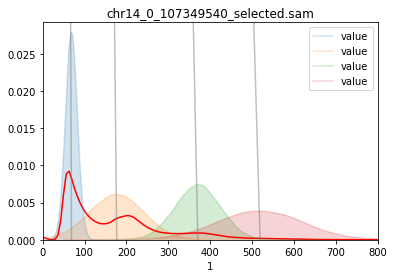

                                            0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:4:23408:14259:1111  632                trinucleo   
1   NS500627:136:HY2CNBGXX:4:11407:12243:5355    0                     Mono   
2   NS500627:136:HY2CNBGXX:2:22206:23075:8095  188                     Mono   
3   NS500627:136:HY2CNBGXX:2:22206:23075:8095  188                     Mono   
4  NS500627:136:HY2CNBGXX:1:13303:20526:15002   86  nucleossome_free_region   

   prob_nucleo_class  
0           0.999905  
1           0.998982  
2           0.998869  
3           0.998869  
4           0.796951  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


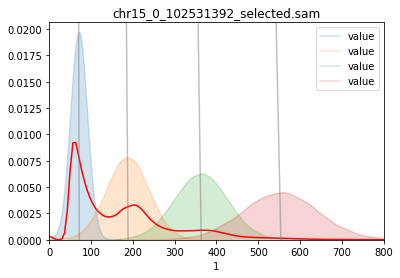

                                            0   1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:3:12606:14776:12511   0  nucleossome_free_region   
1   NS500627:136:HY2CNBGXX:2:11206:26091:7493  77  nucleossome_free_region   
2   NS500627:136:HY2CNBGXX:2:11206:26091:7493  77  nucleossome_free_region   
3    NS500627:136:HY2CNBGXX:1:21304:8464:5879  65  nucleossome_free_region   
4    NS500627:136:HY2CNBGXX:1:21304:8464:5879  65  nucleossome_free_region   

   prob_nucleo_class  
0           0.803788  
1           0.965662  
2           0.965662  
3           0.979095  
4           0.979095  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


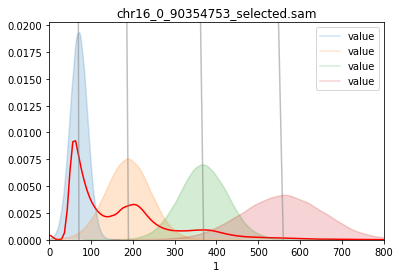

                                            0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:2:12312:3567:11176   83  nucleossome_free_region   
1   NS500627:136:HY2CNBGXX:2:12312:3567:11176   83  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:4:11504:26326:18068  334                 dinucleo   
3   NS500627:136:HY2CNBGXX:3:22409:12372:3122  365                 dinucleo   
4   NS500627:136:HY2CNBGXX:4:22407:3834:19736  154                     Mono   

   prob_nucleo_class  
0           0.942517  
1           0.942517  
2           0.892772  
3           0.965145  
4           0.998651  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


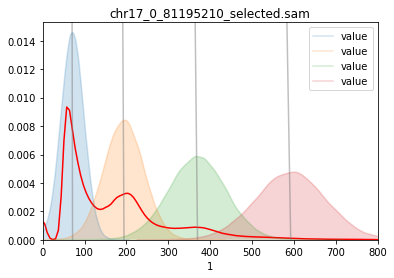

                                           0    1 nucleo_class  \
0   NS500627:136:HY2CNBGXX:1:23309:2330:9226  140         Mono   
1   NS500627:136:HY2CNBGXX:3:12608:4576:6918  205         Mono   
2   NS500627:136:HY2CNBGXX:1:23309:2330:9226  140         Mono   
3  NS500627:136:HY2CNBGXX:1:22203:10301:5893  401     dinucleo   
4   NS500627:136:HY2CNBGXX:3:12608:4576:6918  205         Mono   

   prob_nucleo_class  
0           0.847988  
1           0.985779  
2           0.847988  
3           0.990165  
4           0.985779  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


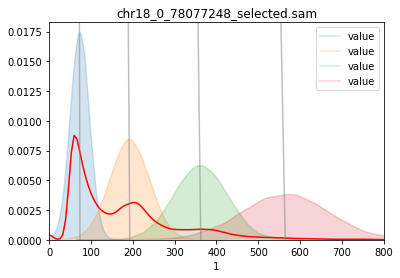

                                            0    1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:4:23510:18304:10048    0  nucleossome_free_region   
1   NS500627:136:HY2CNBGXX:3:23402:21191:8383   52  nucleossome_free_region   
2   NS500627:136:HY2CNBGXX:3:23402:21191:8383   52  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:1:11105:13855:17541  598                trinucleo   
4   NS500627:136:HY2CNBGXX:3:12609:18132:9157  599                trinucleo   

   prob_nucleo_class  
0           0.979919  
1           0.992064  
2           0.992064  
3           0.992385  
4           0.992792  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


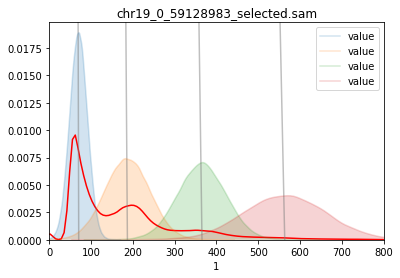

                                            0    1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:3:11412:21098:16891  207                     Mono   
1  NS500627:136:HY2CNBGXX:1:11306:25571:19553   77  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:1:11306:25571:19553   77  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:2:12207:10629:12392   69  nucleossome_free_region   
4  NS500627:136:HY2CNBGXX:2:12207:10629:12392   69  nucleossome_free_region   

   prob_nucleo_class  
0           0.993317  
1           0.954641  
2           0.954641  
3           0.967838  
4           0.967838  
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
saving slices...


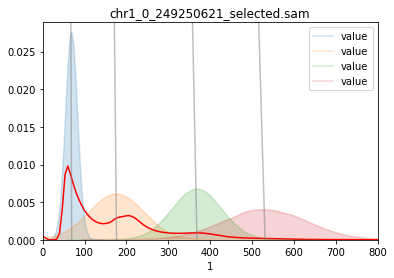

                                            0    1 nucleo_class  \
0  NS500627:136:HY2CNBGXX:4:23401:25461:15431    0         Mono   
1    NS500627:136:HY2CNBGXX:3:21507:2606:4635    0         Mono   
2   NS500627:136:HY2CNBGXX:4:23506:15925:4243    0         Mono   
3   NS500627:136:HY2CNBGXX:1:22201:3177:11842  433     dinucleo   
4    NS500627:136:HY2CNBGXX:3:21507:2606:4635    0         Mono   

   prob_nucleo_class  
0           0.998665  
1           0.998665  
2           0.998665  
3           0.850394  
4           0.998665  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


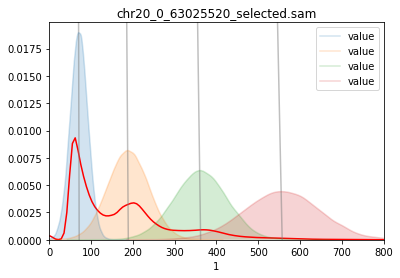

                                            0    1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:3:13512:25569:17697   60  nucleossome_free_region   
1  NS500627:136:HY2CNBGXX:3:13512:25569:17697   60  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:1:12207:22018:18211  179                     Mono   
3  NS500627:136:HY2CNBGXX:4:13604:19915:16049   65  nucleossome_free_region   
4  NS500627:136:HY2CNBGXX:4:13604:19915:16049   65  nucleossome_free_region   

   prob_nucleo_class  
0           0.986384  
1           0.986384  
2           0.995922  
3           0.984063  
4           0.984063  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


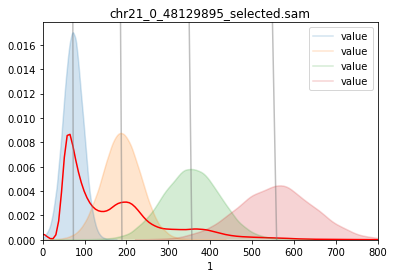

                                            0    1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:4:22407:23763:12749  116  nucleossome_free_region   
1  NS500627:136:HY2CNBGXX:4:22407:23763:12749  116  nucleossome_free_region   
2   NS500627:136:HY2CNBGXX:4:23504:20622:5510  247                     Mono   
3  NS500627:136:HY2CNBGXX:3:12608:17393:18506  361                 dinucleo   
4   NS500627:136:HY2CNBGXX:4:23504:20622:5510  247                     Mono   

   prob_nucleo_class  
0           0.624981  
1           0.624981  
2           0.859722  
3           0.985274  
4           0.859722  
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
saving slices...


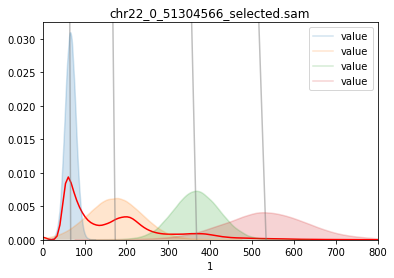

                                            0    1 nucleo_class  \
0   NS500627:136:HY2CNBGXX:1:22306:5067:11068  172         Mono   
1   NS500627:136:HY2CNBGXX:1:22306:5067:11068  172         Mono   
2   NS500627:136:HY2CNBGXX:3:23511:24358:6194  199         Mono   
3   NS500627:136:HY2CNBGXX:4:22501:13001:1094  117         Mono   
4  NS500627:136:HY2CNBGXX:1:13108:16823:13841  360     dinucleo   

   prob_nucleo_class  
0           0.999452  
1           0.999452  
2           0.997233  
3           0.997498  
4           0.911098  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


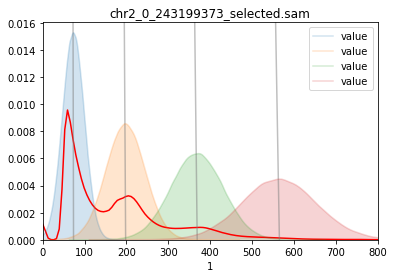

                                           0    1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:2:22210:21185:7949   86  nucleossome_free_region   
1  NS500627:136:HY2CNBGXX:2:22210:21185:7949   86  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:4:22504:3608:18481  236                     Mono   
3   NS500627:136:HY2CNBGXX:2:23205:2050:6621  125  nucleossome_free_region   
4   NS500627:136:HY2CNBGXX:2:23205:2050:6621  125  nucleossome_free_region   

   prob_nucleo_class  
0           0.972680  
1           0.972680  
2           0.961401  
3           0.520872  
4           0.520872  
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
saving slices...


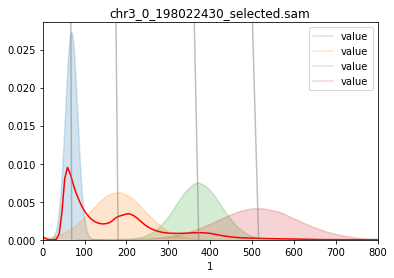

                                           0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:1:21308:3905:3963  236                     Mono   
1   NS500627:136:HY2CNBGXX:3:21605:9806:1452  321                 dinucleo   
2  NS500627:136:HY2CNBGXX:3:11512:22529:8343  183                     Mono   
3  NS500627:136:HY2CNBGXX:1:22303:17066:9432   74  nucleossome_free_region   
4  NS500627:136:HY2CNBGXX:1:22303:17066:9432   74  nucleossome_free_region   

   prob_nucleo_class  
0           0.984111  
1           0.634658  
2           0.999358  
3           0.917305  
4           0.917305  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


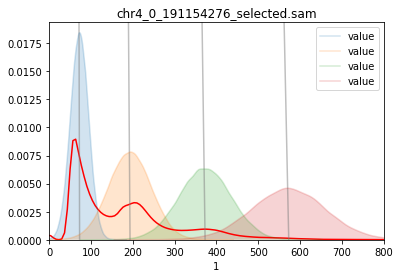

                                            0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:1:13102:3140:10781  117                     Mono   
1   NS500627:136:HY2CNBGXX:4:21404:7640:15482   97  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:2:23209:26081:19780   68  nucleossome_free_region   
3    NS500627:136:HY2CNBGXX:2:12203:7028:2074    0  nucleossome_free_region   
4   NS500627:136:HY2CNBGXX:1:13102:3140:10781  117                     Mono   

   prob_nucleo_class  
0           0.512245  
1           0.888625  
2           0.980409  
3           0.919175  
4           0.512245  
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
saving slices...


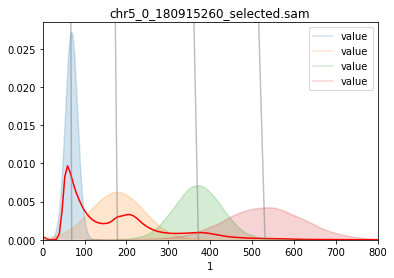

                                            0   1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:3:23401:23424:11347   0                     Mono   
1  NS500627:136:HY2CNBGXX:3:13603:19237:17172  68  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:3:13603:19237:17172  68  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:2:13305:10836:17151   0                     Mono   
4    NS500627:136:HY2CNBGXX:4:22407:5852:7735  81  nucleossome_free_region   

   prob_nucleo_class  
0           0.998105  
1           0.930851  
2           0.930851  
3           0.998105  
4           0.875702  
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
saving slices...


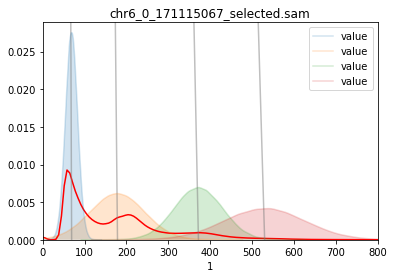

                                            0    1             nucleo_class  \
0    NS500627:136:HY2CNBGXX:1:22202:1379:4379  145                     Mono   
1    NS500627:136:HY2CNBGXX:1:22202:1379:4379  145                     Mono   
2  NS500627:136:HY2CNBGXX:3:12409:16010:14069   70  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:3:12409:16010:14069   70  nucleossome_free_region   
4   NS500627:136:HY2CNBGXX:2:23205:21175:8631  118                     Mono   

   prob_nucleo_class  
0           0.999862  
1           0.999862  
2           0.924532  
3           0.924532  
4           0.984712  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


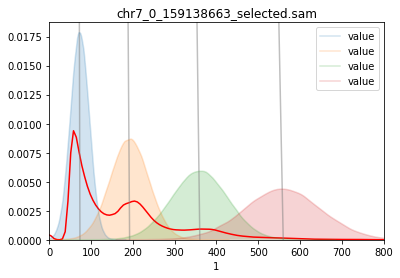

                                            0   1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:2:21309:15825:13464   0  nucleossome_free_region   
1  NS500627:136:HY2CNBGXX:3:11412:26746:18351  62  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:4:22410:17182:12491   0  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:3:11412:26746:18351  62  nucleossome_free_region   
4  NS500627:136:HY2CNBGXX:1:22201:23511:14974   0  nucleossome_free_region   

   prob_nucleo_class  
0           0.984777  
1           0.991516  
2           0.984777  
3           0.991516  
4           0.984777  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


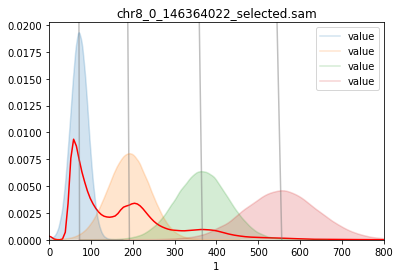

                                            0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:4:21411:24107:9617  169                     Mono   
1   NS500627:136:HY2CNBGXX:4:21411:24107:9617  169                     Mono   
2    NS500627:136:HY2CNBGXX:3:22508:1660:6129   65  nucleossome_free_region   
3    NS500627:136:HY2CNBGXX:3:22508:1660:6129   65  nucleossome_free_region   
4  NS500627:136:HY2CNBGXX:3:11602:15426:17574  105  nucleossome_free_region   

   prob_nucleo_class  
0           0.997766  
1           0.997766  
2           0.983693  
3           0.983693  
4           0.772854  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


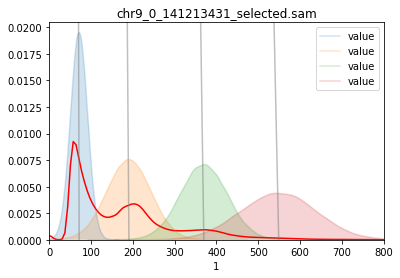

                                            0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:1:21308:1938:19501   57  nucleossome_free_region   
1   NS500627:136:HY2CNBGXX:1:21308:1938:19501   57  nucleossome_free_region   
2  NS500627:136:HY2CNBGXX:4:12412:20772:12960  523                trinucleo   
3   NS500627:136:HY2CNBGXX:4:23401:7759:15466  270                     Mono   
4  NS500627:136:HY2CNBGXX:3:13402:21313:12313  256                     Mono   

   prob_nucleo_class  
0           0.979097  
1           0.979097  
2           0.849289  
3           0.847764  
4           0.927813  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


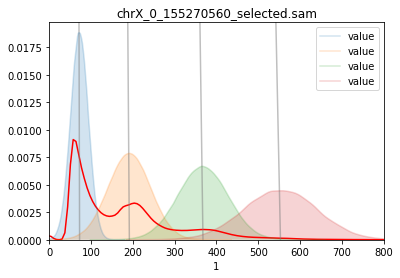

                                            0    1             nucleo_class  \
0  NS500627:136:HY2CNBGXX:3:21409:20333:20307  343                 dinucleo   
1    NS500627:136:HY2CNBGXX:3:13410:5544:3246  204                     Mono   
2   NS500627:136:HY2CNBGXX:1:13204:12572:3242    0  nucleossome_free_region   
3   NS500627:136:HY2CNBGXX:2:13106:9375:18339  444                 dinucleo   
4    NS500627:136:HY2CNBGXX:3:13410:5544:3246  204                     Mono   

   prob_nucleo_class  
0           0.950873  
1           0.993325  
2           0.891820  
3           0.889519  
4           0.993325  
Initialization 0
  Iteration 0
Initialization converged: True
saving slices...


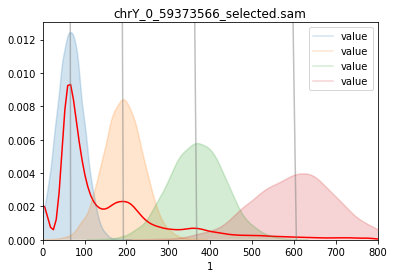

                                           0    1             nucleo_class  \
0   NS500627:136:HY2CNBGXX:2:21108:7232:6482    0  nucleossome_free_region   
1   NS500627:136:HY2CNBGXX:1:11308:1096:1840   82  nucleossome_free_region   
2   NS500627:136:HY2CNBGXX:1:11308:1096:1840   82  nucleossome_free_region   
3  NS500627:136:HY2CNBGXX:3:12412:4439:18140  323                 dinucleo   
4  NS500627:136:HY2CNBGXX:3:12412:4439:18140  323                 dinucleo   

   prob_nucleo_class  
0           0.999324  
1           0.978401  
2           0.978401  
3           0.902546  
4           0.902546  


In [15]:
for f in files_selected: # concact all samples and process this using multiprocessing
    # transform this part in a function 
    m = GaussianMixture(4, means_init=[[50], [200], [400], [600] ] ,verbose=True )

    df_sam_out = pd.read_csv(f,
                             sep='\t',
                             skipfooter=1, header=None)
    
    m.fit(df_sam_out[1].values.reshape(-1,1))

    sns.distplot(df_sam_out[1],
                 color='r',
                 hist=False,
                 bins=800,
                kde=True)
    
    for x in m.means_:
        plt.plot([x,0],[0,1], color='gray', alpha=0.5)
        
    plt.xlim([0,800])

    value, class_sample = m.sample(len( df_sam_out[1]) )

    df_to_fit_model = pd.DataFrame( {'value':[x[0] for x in value.tolist()], 
                   'class_sample':class_sample.tolist() } )

    for k,v in df_to_fit_model.groupby('class_sample'):
        sns.kdeplot (v['value'], shade=True, alpha=0.2)  
    
    nucle_hash_classes = {0:'nucleossome_free_region', 1:'Mono', 2: "dinucleo", 3:"trinucleo" }
    
    df_sam_out['nucleo_class'] = [ nucle_hash_classes[n_p] for n_p in m.predict([[x] for x in df_sam_out[1]])]
    df_sam_out['prob_nucleo_class'] = [max(p) for p in m.predict_proba([[x] for x in df_sam_out[1]])]
    df_sam_out.to_csv(f.replace('.sam', 'separated_info.sam'),header=None, sep='\t', index=None)
    concat_chrs_prediction(df_sam_out, f)
    plt.title(f)
    plt.savefig('distribuition_{}.svg'.format(f))
    plt.show()
    
    
    print df_sam_out.head()

In [29]:
def query_bam_files_read_id (bam_file,
                             bam_read_names,
                            bam_file_name=None):
    if bam_file_name:
        out_name = bam_file_name+'_'+bam_file.replace('.bam', '').split('/')[-1]
    else:
        out_name = bam_file.replace('.bam', '').split('/')[-1]
        
    

    print 'Loading the file {}\n filtering the file  {} \n saving at {}_filtered_reads.bam'.format(bam_file,
                                                                      bam_read_names,
                                                                      out_name)
        
    
    cmd = "picard FilterSamReads I={bam_file} O={out_name}_filtered_reads.bam READ_LIST_FILE={bam_read_names}  FILTER=includeReadList".format(bam_file=bam_file,
                                                                                                                                              bam_read_names=bam_read_names,
                                                                                                                                              out_name=out_name)
     

    os.system(cmd)
    return out_name+'_filtered_reads.bam'

In [30]:
def concat_file_group(bam_file):
    files_to_convert_to_bigwig = []
    f_to_concat = !ls *.out_to_concat
    f_list_hash = {}
    [f_list_hash.setdefault(f_a.split('sam_')[1].split('.')[0],[]).append(f_a) for f_a in f_to_concat]
    #print f_list_hash
    for k,v in f_list_hash.iteritems():
        out_f_vector_name = '{}_df_chr_merged.out'.format(k)
        out_f_vector_name_txt_list = '{}_df_chr_merged.txt'.format(k)
        cmd_0 =  "cat {f_vector} > {out_f_vector_name};cut -f1 {out_f_vector_name} > {out_f_vector_name_txt_list}".format(f_vector=' '.join(v),
                                                                                                                          out_f_vector_name=out_f_vector_name,
                                                                                                                          out_f_vector_name_txt_list=out_f_vector_name_txt_list)
        os.system(cmd_0)
        
        files_to_convert_to_bigwig.append(query_bam_files_read_id(bam_file,
                        out_f_vector_name_txt_list,
                               k))
        
    return files_to_convert_to_bigwig
  

In [27]:
files_to_big_wig = concat_file_group('../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam') 

Loading the file ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam
 filtering the file  trinucleo_df_chr_merged.txt 
 saving at trinucleo_removed_5_filtered_reads.bam
Loading the file ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam
 filtering the file  Mono_df_chr_merged.txt 
 saving at Mono_removed_5_filtered_reads.bam
Loading the file ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam
 filtering the file  nucleossome_free_region_df_chr_merged.txt 
 saving at nucleossome_free_region_removed_5_filtered_reads.bam
Loading the file ../atac_seq_deeplearning/atac_seq_test_dataset/removed_5.bam
 filtering the file  dinucleo_df_chr_merged.txt 
 saving at dinucleo_removed_5_filtered_reads.bam


In [31]:
files_to_big_wig

['trinucleo_removed_5_filtered_reads.bam',
 'Mono_removed_5_filtered_reads.bam',
 'nucleossome_free_region_removed_5_filtered_reads.bam',
 'dinucleo_removed_5_filtered_reads.bam']

In [39]:
#!conda install -c bioconda ucsc-beditemoverlapcount  -y 
#!conda install -c bioconda ucsc-bedgraphtobigwig -y 
#!conda install -c bioconda ucsc-fetchchromsizes -y

In [40]:
for bam in files_to_big_wig:
    !./bam2bigwig.sh $bam

--2018-08-15 20:25:38--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedItemOverlapCount
Resolving hgdownload.soe.ucsc.edu... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16701740 (16M) [text/plain]
Saving to: 'bedItemOverlapCount.4'

bedItemOverlapCount 100%[===================>]  15.93M  5.50MB/s    in 2.9s    

2018-08-15 20:25:41 (5.50 MB/s) - 'bedItemOverlapCount.4' saved [16701740/16701740]

--2018-08-15 20:25:41--  http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/fetchChromSizes
Resolving hgdownload.soe.ucsc.edu... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3336 (3.3K) [text/plain]
Saving to: 'fetchChromSizes.3'

fetchChromSizes.3   100%[===================>]   3.26K  --.-KB/s    in 0s      

2018-08-15 20:25:41 (138 MB/s) - 'fetchChromSizes.3' saved [3336/3336]

INFO: 

In [43]:
!conda install -c bioconda ucsc-fetchchromsizes -y


Solving environment: | 
  - anaconda::ca-certificates-2018.03.07-0, anaconda::certifi-2018.8.13-py27_0
  - anaconda::ca-certificates-2018.03.07-0, defaults::certifi-2018.8.13-py27_0
  - anaconda::certifi-2018.8.13-py27_0, defaults::ca-certificates-2018.03.07-0
  - defaults::ca-certificates-2018.03.07-0, defaults::certifi-2018.8.13-py27done

## Package Plan ##

  environment location: /Users/lxf453/miniconda2

  added / updated specs: 
    - ucsc-fetchchromsizes


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ucsc-fetchchromsizes-366   |       h5eb252a_0           5 KB  bioconda

The following NEW packages will be INSTALLED:

    ucsc-fetchchromsizes: 366-h5eb252a_0 bioconda


ucsc-fetchchromsizes | 5 KB      | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [56]:
def create_bigwig_hg19(bam):

    #! /bin/bash

    #create bed from bam, requires bedtools bamToBed
    !bamToBed -i $bam -split > accepted_hits.bed

    #fetch hg19 chromosome sizes

    !fetchChromSizes hg19 > hg19.chrom.sizes

    #create plus and minus strand bedgraph
    !cat accepted_hits.bed | sort -k1,1 | bedItemOverlapCount hg19 -chromSize=hg19.chrom.sizes stdin | sort -k1,1 -k2,2n > accepted_hits.bedGraph

    #create plus and minus strand bigwig
    !bedGraphToBigWig accepted_hits.bedGraph hg19.chrom.sizes $bam.bw

    #removing intermediery files
    !rm accepted_hits.bed
    !rm accepted_hits.bedGraph
    !rm hg19.chrom.sizes

In [52]:
#!chmod 777 bam2bigwig.sh

In [ ]:
create_bigwig_hg19('trinucleo_removed_5_filtered_reads.bam')

INFO: trying WGET /Users/lxf453/miniconda2/bin/wget for database hg19
url: http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes


In [54]:
!ls -lh *.bw

-rw-r--r--  1 lxf453  CGCENT\Domain Users   6.9M Aug 15 20:33 trinucleo_removed_5_filtered_reads.bam.bw
